In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy.fftpack import fft, fftfreq
import scipy as sp

#import betterplot

from scipy import signal

import umap
import umap.plot

from matplotlib.ticker import MaxNLocator
from scatseisnet import ScatteringNetwork

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from scipy.signal import butter, sosfiltfilt


In [8]:


from sklearn.decomposition import FastICA, PCA, KernelPCA, SparsePCA, IncrementalPCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans

from fastcluster import linkage
from scipy.cluster.hierarchy import fcluster
import umap
# explained_variance_score
from sklearn.metrics import explained_variance_score
from matplotlib import colors
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import explained_variance_score

import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [9]:
freqmin = 1
freqmax = 8
sr = 40

reduce_type = np.mean

name_fig = 'figure05'

name = f"final_version/{name_fig}"

savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name}/"

os.makedirs(savepath, exist_ok=True)



In [10]:


FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

vs_hr = np.load(FILEPATH+'vs_map_2400x1300.npy')
vs_hr = vs_hr/1000

vs = np.load(FILEPATH+'vs_array.npy') 
vs = vs/1000

data_records_vs = []
for i in range(1, 6):
    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/z_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/z_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_vs.append(data_read)
data_records_vs = np.array(data_records_vs) 

sos = butter(10, freqmax, 'lp', fs=40, output='sos')
data_records_vs = sosfiltfilt(sos, data_records_vs[:,:,:], axis=-1)
data_records_vs = np.concatenate(data_records_vs, axis = 1)
data_records_vs = data_records_vs[:, :, ::2]


data_records_hs = []
for i in range(1, 6):    
    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/x_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/x_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_hs.append(data_read)
data_records_hs = np.array(data_records_hs)


sos = butter(10, freqmax, 'lp', fs=40, output='sos')
data_records_hs = sosfiltfilt(sos, data_records_hs[:,:,:], axis=-1)
data_records_hs = np.concatenate(data_records_hs, axis = 1)
data_records_hs = data_records_hs[:, :, ::2]



In [11]:



segment_duration_seconds = data_records_hs.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 6, "quality": 1, "taper_alpha" : 0.},
    {"octaves": 5 , "resolution": 3, "quality": 2, "taper_alpha" : 0.},
     )


network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )



for i, bank in enumerate(network.banks):
    print(f"Bank {i}")
    print(bank)
    for j in range(bank.wavelets.shape[0]):
        network.banks[i].wavelets[j] = network.banks[i].wavelets[j] / np.sqrt((np.abs(network.banks[i].wavelets[j])**2).sum())

network.banks[0].spectra = np.fft.fft(network.banks[0].wavelets)
network.banks[1].spectra = np.fft.fft(network.banks[1].wavelets)


print(network)



TypeError: ComplexMorletBank.__init__() got an unexpected keyword argument 'taper_alpha'

In [16]:
np.linalg

<module 'numpy.linalg' from '/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/numpy/linalg/__init__.py'>

/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


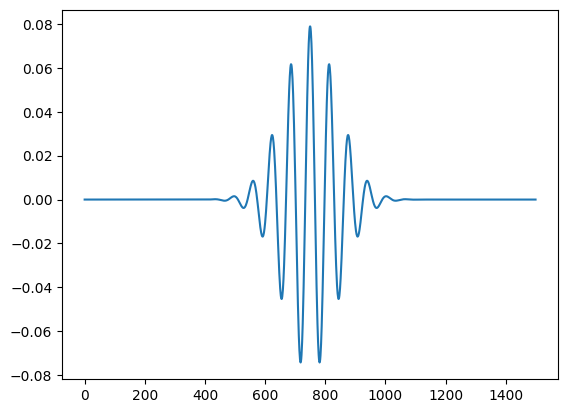

In [9]:
plt.plot(network.banks[i].wavelets[j])


NameError: name 'network' is not defined

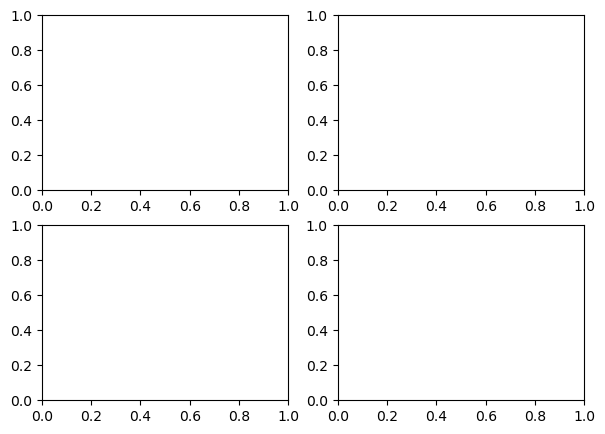

In [5]:

# Loop over network layers
#plt.figure(figsize=(10,5))

#cc = low_pass_filter(2000, sigma = 0.2)
fig, ax = plt.subplots(2, 2, figsize=(7,5),  )


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)
        #ax[i,0].plot(bank.times, wavelet.imag + ratio, c='r', lw = 0.5)

        # Spectral domain (log of amplitude)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)
        #ax[i,2].plot(bank.frequencies, np.log(np.abs(spectrum*cc[1000:]) + 1) + ratio, c = 'b', lw = 0.5)
        
    #ax[0,1].plot(bank.frequencies, np.log(np.abs(cc[1000:]) + 1) -0.25, c = 'r', lw = 0.5)

    # Limit view to three times the temporal width of largest wavelet
    width_max = 2 * bank.widths.max()

    # Labels
    
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    #ax[i, 0].set_xlim(0.1, 50)
    #  
    #ax[i,2].set_xscale("log")
    #ax[i,2].set_xlabel("Frequency (Hz)")
    #ax[i,2].grid()
    #ax[i, 1].set_xlim(0.1, 50)
    
    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

fig.tight_layout()
#fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)




In [6]:

time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]


fig, axs = plt.subplots(2, 1, figsize = (4, 3))

axs[0].plot(time, data[indxvs[75, 30], 0, :].T,lw = 0.75, c = 'k')

axs[1].plot(time, data[indxvs[75, 30], 1, :].T,lw = 0.75, c = 'k')


ax = axs[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

ax = axs[1]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

fig.tight_layout()
#fig.savefig(savepath + f'seismograms.pdf', transparent=True)



NameError: name 'data' is not defined

In [12]:
segments = [data[i,:,:] for i in indxvs[indx, 30]]



sc1 = network.transform(segments,  reduce_type= None )



In [8]:
time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]



In [9]:

def reader_coeff(path_file):

    scm_ = np.load(path_file)

    sc = [scm_['order_1'], scm_['order_2']]

    for i in range(len(network.banks[0].centers)):
        n = network.banks[0].centers[i] <= network.banks[1].centers
        sc[1][:,:, i, n] = np.nan

    return sc

sc_med_20_hs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_com_hs_median_20.npz"
sc_med_20_vs = "/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_com_vs_median_20.npz"


scm_norm_hs = reader_coeff(sc_med_20_hs)
scm_norm_vs = reader_coeff(sc_med_20_vs)



FileNotFoundError: [Errno 2] No such file or directory: '/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_normalized_l2_wavelet_unnormalized_median.npz'

/tmp/ipykernel_242882/1219354726.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


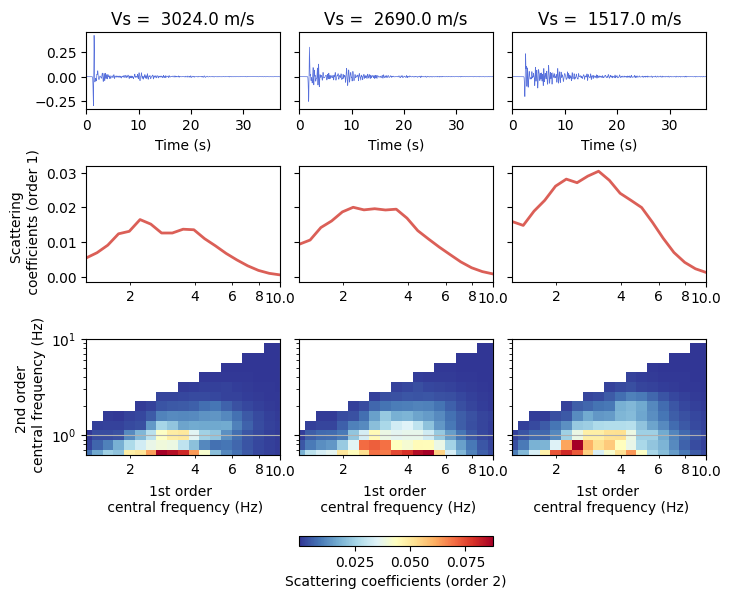

In [15]:
from matplotlib.ticker import ScalarFormatter


sc = scm_norm


gs = {"hspace": 0.4, "wspace": 0.1, "height_ratios": [1,1.5, 3]}
fig, axs = plt.subplots(
        3, 3, figsize=(8, 7), sharex="row", sharey="row", gridspec_kw=gs
    )


offset_x = 30

trc = [35, 55, 80]

ax = axs[0].reshape(-1)

for i, ind in enumerate(trc):

    ax[i].set_title(f"Vs =  {np.ceil(vs.reshape(-1)[indxvs[ind, offset_x]])} m/s")
    ax[i].plot(np.arange(len(data[0,0,:]))/40, data[indxvs[ind, offset_x],0,:], lw = 0.5,  c = '#5770db')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim(0, 37)

    
ax = axs[1].reshape(-1)


for i, ind in enumerate(trc):
    ss = sc[0][indxvs[ind, offset_x]][0]
    sss = ss #- np.mean(sc[0][:, 0, :], axis = 0)
    sss = abs(sss)
    
    ax[i].plot(network.banks[0].centers, (sss), lw = 2,  c = '#db5f57')
    #ax[i].set_ylim(0, 0.1)
    #ax[i].plot(network.banks[0].centers, (sc2[0][indxvs[ind, offset_x]][0]), lw = 2,  c = 'k')
    ax[i].set_xlim(network.banks[0].centers.min(), 10)

    #ax[i].set_xlabel('1st order \n frequency (Hz)')
    ax[i].xaxis.set_minor_locator(MaxNLocator(nbins=5))
    ax[i].set_xscale("log")

    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax[i].xaxis.set_minor_formatter(formatter)
    ax[i].xaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_minor_locator(MaxNLocator(nbins=5))



ax[0].set_ylabel("Scattering \n coefficients (order 1)")
            
ax = axs[2].reshape(-1)

for i, ind in enumerate(trc):

    ss = (sc[1][indxvs[ind, offset_x]][0])
    #ss[np.isnan(ss)] = 0 
    sss = ss #- np.mean(sc[1][:, 0, : ,:], axis = 0) 
    sss = abs(sss)
    img = ax[i].pcolormesh(network.banks[0].centers, network.banks[1].centers, ((sss.T)*1), cmap = 'RdYlBu_r', rasterized=True ) 
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")

    ax[1].set_xlim(network.banks[0].centers.min(), 10)
    ax[1].set_ylim(network.banks[1].centers.min(), 10)

    ax[i].grid(True)

    ax[i].set_xlabel('1st order \n central frequency (Hz)')
    #ax[i].tick_params(axis='x', labelrotation=45)


    #ax[i].gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax[i].xaxis.set_minor_formatter(formatter)
    ax[i].xaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_minor_locator(MaxNLocator(nbins=5))

    for text in ax[i].get_xminorticklabels():
        text.set_rotation(0)


    cb = plt.colorbar(img, ax=ax[i], orientation="horizontal", pad=0.35)
    cb.set_label("Scattering coefficients (order 2)")
    if i != 1:
        cb.ax.set_visible(False)


ax[0].set_ylabel('2nd order \n central frequency (Hz)')

fig.tight_layout()

plt.savefig(savepath + "Coefficients" + ".png", bbox_inches="tight", dpi=300, transparent=True,)


In [16]:

def normalizing(scattering_coefficients, sil = 5):
    
    ss = scattering_coefficients.copy()
    
    c1 = ss[0].copy()
    c2 = ss[1].copy()

    c2hat = c2/ (np.nanmedian(c1, -1) + sil + 0* np.nanmax(c1, -1) )[:,:,np.newaxis , np.newaxis] 

    c2hat[np.isnan(scattering_coefficients[1])] == np.nan
    
    return [c1, c2hat]
    



In [10]:


from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize, PowerTransformer, QuantileTransformer, StandardScaler

hfreq = 0

def process__(scc, indx = None):
    
    #sc = normalizing(scc, sil = 1e-15)
    sc = scc.copy()

    if indx == None:
        indx = np.arange(sc[0].shape[1])
        order_1 = sc[0][:, ::2, hfreq:]
        order_2 = sc[1][:, ::2, hfreq:, :]

    elif indx == 'avg':
        order_1 = np.nanmedian(sc[0][:, ::2, hfreq:], axis = 1)
        order_2 = np.nanmedian(sc[1][:, ::2, hfreq:, :], axis = 1)

    else:
        indx = indx
        order_1 = sc[0][:, indx, hfreq:]
        order_2 = sc[1][:, indx, hfreq:, :]

    #print(order_1)

    #scc = normalizing(sc, sil = 1e-1)

    order_1 = order_1.reshape(order_1.shape[0] , -1)
    order_2 = order_2.reshape(order_2.shape[0], -1)
    
    coeff =  np.hstack((order_1, order_2))

    coeff =  np.log((coeff[:, :]) + 1e-10)# * np.nanmax(coeff) )

    coef = np.nan_to_num(coeff, 0)

    #coef = MinMaxScaler(feature_range = (-1, 1)).fit_transform(coef)

    coef  = StandardScaler().fit_transform(coef)
    
    return coef


#scm_norm = reader_coeff(scm1)
#scm_unnorm = reader_coeff(scm2)
#scm_coda = reader_coeff(scm3)


In [11]:

network.banks[0].centers, 


NameError: name 'network' is not defined

In [12]:

def Reduceing(model, data, n):

    reducing_model = model(n_components= n , random_state = 0, max_iter= 1000, tol = 1e-20)
    features = reducing_model.fit_transform(data)
    iv  = reducing_model.inverse_transform(features)
    varaince = explained_variance_score(data, iv)

    return features, varaince

from string import ascii_uppercase
    
#dd = MinMaxScaler(feature_range = (-1, 1)).fit_transform()

def heir_cluster(features, threshold = 1, CLUSTERS = 5):
    
    linkage_matrix = linkage(features, "ward", metric = 'cityblock')    

    META_THRESHOLD = threshold * linkage_matrix[:, 2].max()
    # Find meta cluster

    clusters =  fcluster(linkage_matrix, CLUSTERS, criterion='maxclust')
    
    
    meta_clusters  = fcluster(linkage_matrix, META_THRESHOLD, criterion="distance")
    
    cluster_indexes = np.arange(CLUSTERS) +1
    
    correspondance = np.zeros_like(cluster_indexes)
    for i, cluster in enumerate(cluster_indexes):
        correspondance[i] = np.unique(meta_clusters[clusters == cluster])[0]

    meta_clusters_labels, meta_clusters_counts = np.unique(
        correspondance, return_counts=True
    )
    labels = []
    for n in meta_clusters_counts:
        # If the cluster contains more than one sub-cluster, number them from 1 to n
        if n > 1:
            labels.extend(list(range(1, n + 1)))

        # If the cluster contains only one sub-cluster, leave it without number
        else:
            labels.append("")


    labels = [
        f"{ascii_uppercase[c - 1]}{l}" for c, l in zip(correspondance, labels)
    ]

    colors = []
    shift = 1
    for label in labels:
        if len(label) > 1:
            colors.append(f"C{ascii_uppercase.index(label[:1]) + shift}")
        else:
            shift -= 1
            colors.append("C0")
    
    #colors  = sns.color_palette("hls", np.unique(meta_clusters).shape[0])

    return linkage_matrix, clusters, colors


from scipy.cluster.hierarchy import dendrogram
from matplotlib.colors import ListedColormap


def dendo(link, CLUSTERS, ax, threshold = 0.3):

    with plt.rc_context({"lines.linewidth": 1}):
        
        dendrogram(link ,
                CLUSTERS,
                orientation="top",
                truncate_mode="lastp",
                ax = ax,
                color_threshold = threshold * link[:, 2].max(),
                above_threshold_color="k",
                no_labels=True,

        )
        

In [20]:


coef_4 = process__(scm_unnorm, indx = 4)
coef_avg = process__(scm_unnorm, indx = 'avg')
coef_all = process__(scm_unnorm, indx = None)
coef_2 = process__(scm_norm, indx = None)


mdl = FastICA

d = np.arange(1, 20, 1)

variance_4 = []
ariance_avg = []
ariance_all = []
ariance_norm = []

for i in d:

    features_1, variance_1 = Reduceing(mdl, coef_4, i)
    features_2, variance_2 = Reduceing(mdl, coef_avg, i)
    features_3, variance_3 = Reduceing(mdl, coef_all, i)
    features_4, variance__4 = Reduceing(mdl, coef_2, i)

    variance_4.append(variance_1)
    ariance_avg.append(variance_2)
    ariance_all.append(variance_3)
    ariance_norm.append(variance__4)
    print(i)



/tmp/ipykernel_242882/4189340870.py:17: RuntimeWarning: All-NaN slice encountered
  order_2 = np.nanmedian(sc[1][:, ::2, hfreq:, :], axis = 1)


1


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


2


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


3


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


4


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


5


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


6


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


7


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


8


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


9


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


10


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


11


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


12


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


13


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


14


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


15


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


16


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


17


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


18


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


19


In [21]:
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)



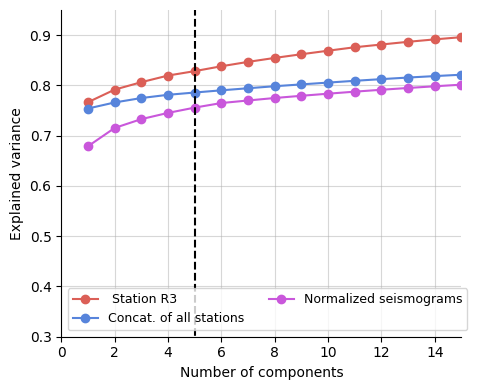

In [22]:


fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.plot(d, variance_4, 'o-', label = ' Station R3', c = "#db5f57")
# ax.plot(d, ariance_avg, 'o-', label = 'avg. of all stations', c = '#57db94')
ax.plot(d, ariance_all, 'o-', label = 'Concat. of all stations', c = '#5784db')
ax.plot(d, ariance_norm, 'o-', label = 'Normalized seismograms', c = '#c957db')


ax.set_xlabel('Number of components')
ax.set_ylabel('Explained variance')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend( fontsize = 9 , ncol = 2)
ax.vlines(5, 0.,1.1, linestyle = '--', color = 'k')

ax.set_ylim(0.3, 0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 15])
ax.grid(alpha = 0.5)

plt.tight_layout()
plt.savefig(savepath + 'explained_variance.pdf', dpi = 300, transparent=True)




In [23]:

coef_4 = process__(scm_unnorm, indx = 4)
#coef_avg = process__(scm_unnorm, indx = 'avg')
coef_all = process__(scm_unnorm, indx = None)
coef_2 = process__(scm_norm, indx = None)


mdl = FastICA

NCOMPT = 5


features__4, variance_4 = Reduceing(mdl, coef_4, NCOMPT)
#features_avg, variance_avg = Reduceing(mdl, coef_avg, NCOMPT)
features_all, variance_all = Reduceing(mdl, coef_all, NCOMPT)

features__1, variance_1 = Reduceing(mdl, coef_2, NCOMPT)

variance_4, variance_all, variance_1


/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


(0.8283859804336816, 0.7858167964879734, 0.7558141406930386)

/tmp/ipykernel_1137576/795959277.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


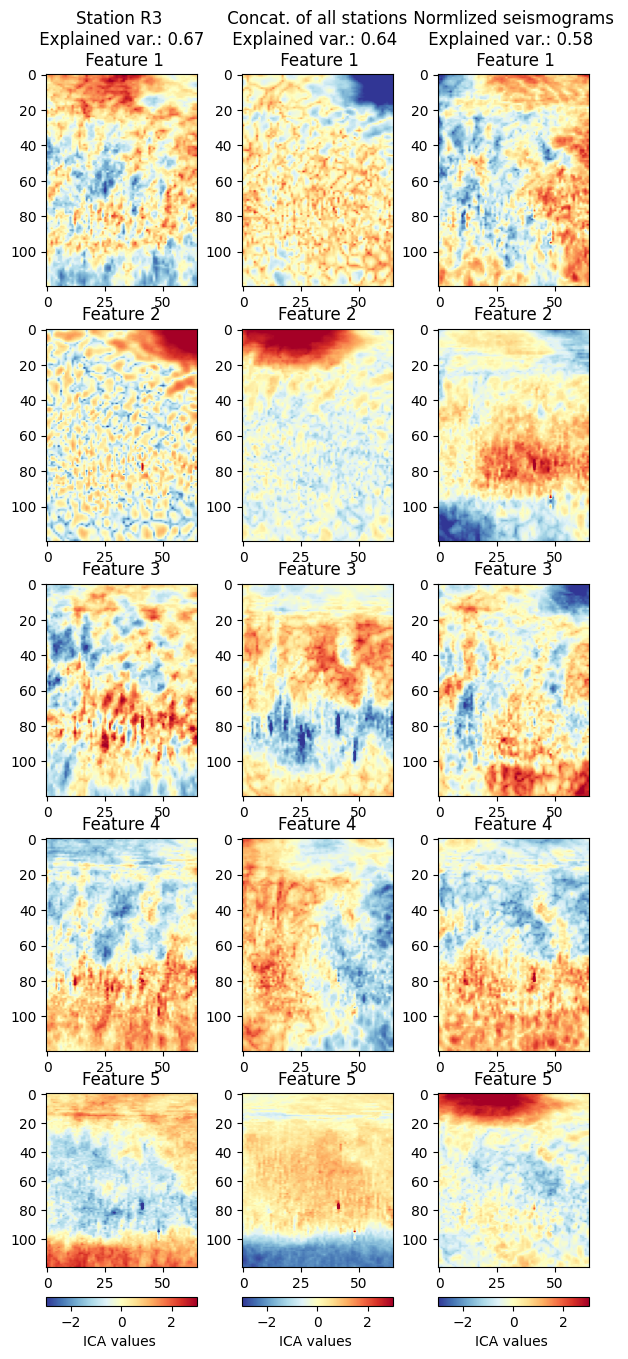

In [35]:
gs = {"hspace": 0.2, "wspace": 0.3}

fig, axs = plt.subplots(NCOMPT, 3, figsize = (7 , 16), gridspec_kw=gs)
axs = axs.T

vmax = 3
vmin = -3
CMAP = 'RdYlBu_r'
ax = axs[0]



for i in range(NCOMPT):

    im1 = ax[i].imshow((features__4[:, i].reshape(120, 65)), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax, rasterized=True)
    divider = make_axes_locatable(ax[i])
    if i == 0:
       ax[0].set_title(f'Station R3 \n Explained var.: {variance_4:.2f} \n Feature {i+1}')
    else:
        ax[i].set_title(f'Feature {i+1}')

cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'ICA values ')


# ax = axs[1]

# for i in range(NCOMPT):
#     im1 = ax[i].imshow((features_avg[:, i].reshape(120, 65)), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax, rasterized=True)
#     if i == 0:
#         ax[0].set_title(f'Avg. of all stations \n Explained var.: {variance_avg:.2f} \n Feature {i+1}')
#     else:
#         ax[i].set_title(f'Feature {i+1}')

# divider = make_axes_locatable(ax[i])
# cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
# cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'Absolute values ')


ax = axs[1]


#ax[0].set_title(f'Concat. of all stations \n Explained var.: {variance_all:.2f}')

for i in range(NCOMPT):
    im1 = ax[i].imshow((features_all[:, i].reshape(120, 65)), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax, rasterized=True)

    if i == 0:
        ax[0].set_title(f' Concat. of all stations \n Explained var.: {variance_all:.2f}  \n Feature {i+1}')
    else:
        ax[i].set_title(f'Feature {i+1}')

divider = make_axes_locatable(ax[i])
cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'ICA values ')



ax = axs[2]


#ax[0].set_title(f'Concat. of all stations \n Explained var.: {variance_all:.2f}')

for i in range(NCOMPT):
    im1 = ax[i].imshow((features__1[:, i].reshape(120, 65)), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax, rasterized=True)

    if i == 0:
        ax[0].set_title(f' Normlized seismograms \n Explained var.: {variance_1:.2f}  \n Feature {i+1}')
    else:
        ax[i].set_title(f'Feature {i+1}')

divider = make_axes_locatable(ax[i])
cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'ICA values ')



plt.tight_layout()

plt.savefig(savepath + 'ICA_components.pdf', dpi = 300, transparent=True)



In [36]:
CLUSTERS = 50
threshold = 0.4


from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
sil2 = []

featureforsill = features_all
#featureforsill = features__1

for i in range_n_clusters:

    #X, variance_norm = Reduceing(mdl, coef_all, i)

    linkage_1, clusters_1, colors_1 = heir_cluster(featureforsill, threshold = threshold, CLUSTERS = i)

    print(np.unique(clusters_1)) 
    #cluster_labels = clustering_norm

    silhouette_avg = silhouette_score(featureforsill, clusters_1 )

    sil2.append(silhouette_avg)




[1 2]
[1 2 3]
[1 2 3 4]
[1 2 3 4 5]
[1 2 3 4 5 6]
[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


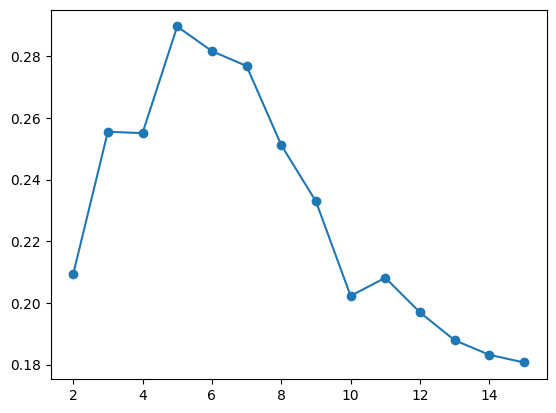

In [37]:
plt.plot(range_n_clusters, sil2, 'o-')


In [38]:


import seaborn as sns

cmap2 = sns.color_palette("hls", 7)

print(cmap2.as_hex())



['#db5f57', '#dbd057', '#75db57', '#57dbaa', '#579bdb', '#8557db', '#db57c0']


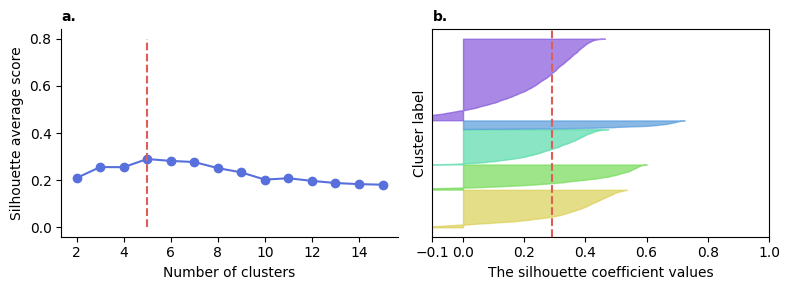

In [39]:
from sklearn.datasets import make_blobs
import matplotlib.cm as cm


linkage_1, clusters_1, colors_1 = heir_cluster(featureforsill, threshold = threshold, CLUSTERS = 5)
silhouette_avg = silhouette_score(featureforsill, clusters_1 )


fig, axs = plt.subplots(1, 2,  figsize = (8, 3))
n_clusters = len(np.unique(clusters_1))+1


axs[0].plot(np.asarray(range_n_clusters), sil2, 'o-', c ='#5770db')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Silhouette average score')
axs[0].vlines(n_clusters-1, 0.0, 0.8, linestyle = '--', color = '#db5f57')
i#axs[0].set_ylim(0.1, 0.4)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sample_silhouette_values = silhouette_samples(featureforsill, clusters_1)
y_lower = 10
axs[0].set_title('a.', loc = 'left', fontsize = 10, fontweight = 'bold')

ax1 = axs[1]
ax1.set_title('b.', loc = 'left', fontsize = 10, fontweight = 'bold')

for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusters_1 == i]

    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=cmap2.as_hex()[i],
        edgecolor=cmap2.as_hex()[i],
        alpha=0.7,
    )
    # Label the silhouette plots with their cluster numbers at the middle
    #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="#db5f57", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlim(-0.1, 1)

fig.tight_layout()

fig.savefig(savepath + 'silhouette_score.pdf', dpi = 300, transparent=True)


In [40]:
CLUSTERS = 100
threshold = 0.5

linkage_1, clusters_1, colors_1 = heir_cluster(features__4, threshold = threshold, CLUSTERS = CLUSTERS)
#linkage_2, clusters_2, colors_2 = heir_cluster(features_avg, threshold = threshold, CLUSTERS = CLUSTERS)
linkage_3, clusters_3, colors_3 = heir_cluster(features_all, threshold = threshold, CLUSTERS = CLUSTERS)
linkage_4, clusters_4, colors_4 = heir_cluster(features__1, threshold = threshold, CLUSTERS = CLUSTERS)

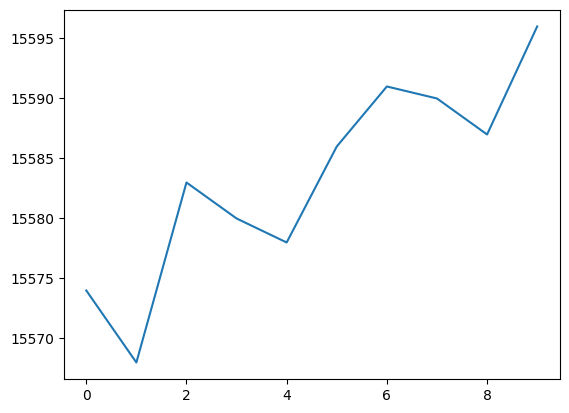

In [41]:
plt.plot(linkage_1[-10:, 0])


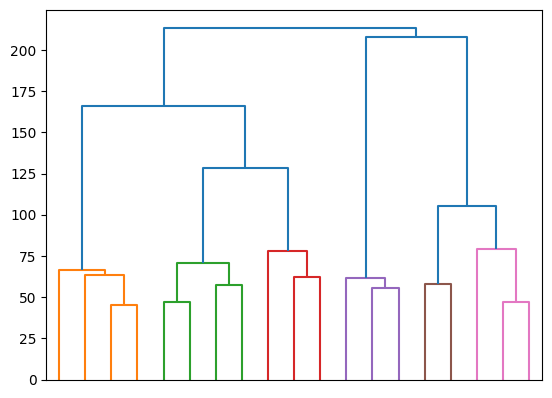

In [42]:
cc = dendrogram(linkage_1 ,
                19,
                truncate_mode="lastp",
                orientation="top",
                color_threshold =  100, 
                # above_threshold_color="k",
                no_labels=True,
            )


/tmp/ipykernel_1137576/739201055.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


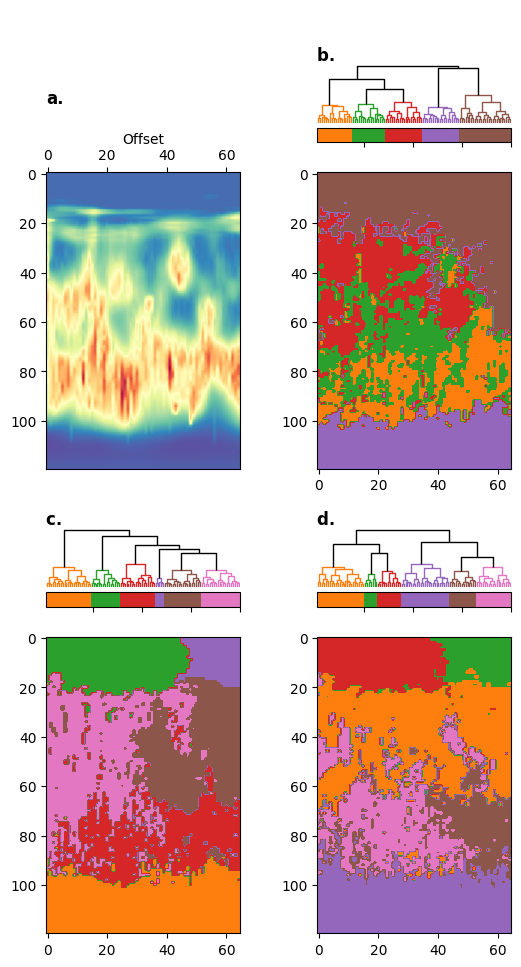

In [43]:

gs = {"hspace": 0.02 , "wspace": 0.4, "height_ratios": [1.,3, 1., 3]}
fig, axss = plt.subplots(
        4, 2, figsize=(6, 12),  gridspec_kw=gs,
    )

axss = axss.T.reshape(-1)
axss1 = axss[::2]
axss2 = axss[1::2]
#axss = axss.T

axs = axss1[0]

axs.set_axis_off()

axs = axss2[0]

im1 = axs.imshow(vs.reshape(120, 65), cmap = 'Spectral', aspect = 'auto')
#divider = make_axes_locatable(axs[0])
divider = make_axes_locatable(axs)
cax1 = divider.append_axes('top', size='5%', pad=0.3, )
#cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, )
cax1.set_axis_off()
axs.set_title('a.\n ', loc = 'left', fontsize = 12, fontweight="bold")

axs.set_xlabel('Offset')
axs.xaxis.set_label_position('top') 
axs.xaxis.tick_top()


cbar.set_label('Vs (m/s)', labelpad=-40, y=1.05, rotation=0)



ll = ['b', 'c', 'd', 'e', 'f']
i = 0

for axsind, link, clus, colls in zip([2, 1, 3], [linkage_1, linkage_3, linkage_4 ], [clusters_1,clusters_3, clusters_4], [ colors_1, colors_3, colors_4]):

    ax = axss1[axsind]
    dendo(link, CLUSTERS, ax, threshold = threshold)
    ax.set_ylim(0, link[:, 2].max() * 2)
    ax.set_axis_off()

    #plt.vlines(META_THRESHOLD, 0, 1000, colors='r', linestyles='dashed')
    ax = axss2[axsind]
    ax.set_title(ll[i]+'. \n \n \n \n \n', loc = 'left', fontsize = 12, fontweight="bold")
    i = i+1


        
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes('top', size='5%', pad=0.3, )
    

    cmap = ListedColormap(colls)

    im1 = ax.imshow(clus.reshape(120, 65),cmap = cmap, aspect='auto', rasterized=True)
    #plt.colorbar(im, ax = cax1)

    cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35)
    cbar.set_ticklabels([])

    #ax.set_axis_off()

plt.tight_layout()
plt.savefig(savepath + 'clustering_all.pdf', dpi = 300, transparent=True)



In [ ]:
#scm_norm = reader_coeff(scm1)
#scm_unnorm = reader_coeff(scm2)
#scm_coda = reader_coeff(scm3)


coef_1 = process__(scm_unnorm, indx = None)
coef_2 = process__(scm_norm, indx = None)

#coef_2  = RobustScaler().fit_transform(coef_2.T).T

coef_3 = process__(scm_coda, indx = None)



mdl = FastICA

NCOMPT = 2


features__1, variance_1 = Reduceing(mdl, coef_2, NCOMPT)
features__2, variance_2 = Reduceing(mdl, coef_3, NCOMPT)

features__3, variance_3 = Reduceing(mdl, coef_3, NCOMPT)

variance_1, variance_2, variance_3



In [ ]:
gs = {"hspace": 0.2, "wspace": 0.4}

fig, axs = plt.subplots(1,2, figsize = (5.6, 4), gridspec_kw=gs)
axs = axs.T

vmax = 2.5
vmin = 0
CMAP = 'Spectral'
ax = axs


ax[0].set_title(f'Unnormalized data \n (all stations) \n Explained var.: {variance_1:.2f}')

for i in range(2):

    im1 = ax[i].imshow(abs(features__1[:, i].reshape(120, 65)), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax)

divider = make_axes_locatable(ax[i])
cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'ICA components {i+1}')


ax = axs[1]



#ax[0].set_title(f'Late-coda normalization \n (all stations) \n Explained var.: {variance_2:.2f}')


#for i in range(2):
#    im1 = ax[i].imshow(features__2[:, i].reshape(120, 65), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax)

#divider = make_axes_locatable(ax[i])
#cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
#cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'ICA components {i+1}')


# ax = axs[2]

# ax[0].set_title(f'Concat. of all sources \n Explained var.: {variance_3:.2f}')

# for i in range(2):
#     im1 = ax[i].imshow(features_3[:, i].reshape(120, 65), cmap = CMAP, aspect = 'auto', vmin = vmin, vmax = vmax)
#     divider = make_axes_locatable(ax[i])
#     cax1 = divider.append_axes('bottom', size='5%', pad=0.3, )
#     cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, label = f'ICA components {i+1}')

plt.tight_layout()

plt.savefig(savepath + 'ICA_components_normalized.pdf', dpi = 300, transparent=True)



In [ ]:
CLUSTERS = 50
threshold = 0.28

linkage_1, clusters_1, colors_1 = heir_cluster(features__1, threshold = threshold, CLUSTERS = CLUSTERS)
linkage_2, clusters_2, colors_2 = heir_cluster(features__2, threshold = threshold, CLUSTERS = CLUSTERS)



In [ ]:



gs = {"hspace": 0.01, "wspace": 0.4, "height_ratios": [0.5,3]}
fig, axss = plt.subplots(
        2, 2, figsize=(5, 4.5),  gridspec_kw=gs
    )


axss = axss.T


axs = axss[0]
axs[0].set_axis_off()
im1 = axs[1].imshow(vs.reshape(120, 65), cmap = 'Spectral', aspect = 'auto')
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes('top', size='5%', pad=0.3, )
cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35, )

cbar.set_label('Vs (m/s)', labelpad=-40, y=1.05, rotation=0)



for axs, link, clus, colls in zip(axss[1:,:], [linkage_1 ], [clusters_1], [ colors_1]):

    ax = axs[0]
    dendo(link, CLUSTERS, ax, threshold = threshold)

    ax.set_axis_off()
    #plt.vlines(META_THRESHOLD, 0, 1000, colors='r', linestyles='dashed')

    ax = axs[1]

    
        
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes('top', size='5%', pad=0.3, )
    

    cmap = ListedColormap(colls)

    im1 = ax.imshow(clus.reshape(120, 65),cmap = cmap, aspect='auto', rasterized=True)
    #plt.colorbar(im, ax = cax1)

    cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35)
    cbar.set_ticklabels([])

    #ax.set_axis_off()

fig.tight_layout()
fig.savefig(savepath + 'clustering_normalized.pdf', dpi = 300, transparent=True)


In [ ]:

#plt.plot(range_n_clusters, sil, 'o-')
plt.plot(range_n_clusters, sil2, 'o-')

In [ ]:

range_n_clusters

In [ ]:

gs = {"hspace": 0.01, "wspace": 0.2, "height_ratios": [0.5,3]}
fig, axss = plt.subplots(
        2, 2, figsize=(6, 6),  gridspec_kw=gs
    )

axss = axss.T

for axs, link, clus, colls in zip(axss, [linkage_unnorm, linkage_norm ], [clusters_unnorm, clusters_norm], [ colors_unnorm, colors_norm]):

    ax = axs[0]
    dendo(link, CLUSTERS, ax, threshold = 0.3)

    ax.set_axis_off()
    #plt.vlines(META_THRESHOLD, 0, 1000, colors='r', linestyles='dashed')

    ax = axs[1]


        
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes('top', size='5%', pad=0.3, )
    


    cmap = ListedColormap(colls)

    im1 = ax.imshow(clus.reshape(120, 65),cmap = cmap, aspect='auto', rasterized=True)
    #plt.colorbar(im, ax = cax1)

    cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.35)
    cbar.set_ticklabels([])

    #ax.set_axis_off()


In [ ]:
coefficients_unnorm.shape

In [ ]:

d = np.arange(2, 14, 1)

variance_coda_all = []
for i in d:

    features_coda, variance_coda = Reduceing(mdl, coefficients_norm, i)
    variance_coda_all.append(variance_coda)

#clustering_coda = clustering(features_coda, threshold = threshold, CLUSTERS = CLUSTERS)


In [ ]:

plt.plot(d, variance_coda_all)


In [ ]:
fig, axs = plt.subplots(1,NCOMPT , figsize = (NCOMPT*2, 5))

for i in range(NCOMPT):
    
    ax = axs[i]
    im = ax.imshow(features_unorm[:, i].reshape(120, 65), aspect = 'auto', cmap = 'RdYlBu_r')
    plt.colorbar(im, ax = ax, orientation = 'horizontal', label = 'ICA 1')
    

In [ ]:
threshold = None#0.25

CLUSTERS = 8
clustering_norm = clustering(features_norm, threshold = threshold, CLUSTERS = CLUSTERS)
clustering_unorm = clustering(features_unorm, threshold = threshold, CLUSTERS = CLUSTERS)
clustering_coda = clustering(features_coda, threshold = threshold, CLUSTERS = CLUSTERS)



In [ ]:

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs



range_n_clusters = [ 4, 5, 6, 7, 8, 9]

X = features

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
    #fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)
    X = features_norm

    clustering_norm = clustering(X, threshold = threshold, CLUSTERS = n_clusters)

    cluster_labels = clustering_norm

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space (1st)")
    # ax2.set_ylabel("Feature space (2nd)")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering with n_clusters = %d"
        % n_clusters,
        fontweight="bold",
    )


    plt.tight_layout()

    #plt.savefig(savepath+f'silhouette_{i}.png', bbox_inches="tight", dpi=300)

    plt.show()





In [ ]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

gs = {"hspace": 0.4, "wspace": 0.2}
fig, axs = plt.subplots(1, 2,  dpi = 300, figsize = (6, 4), sharex = True, sharey = True, gridspec_kw=gs)

for i, modelcluster in enumerate(zip([clustering_unorm, clustering_norm], ['Unnormalized data', 'Normalized data'])):
    
    ax = axs[i]

    clusters = modelcluster[0]
    
    im1 = ax.imshow(clusters.reshape(120, 65), cmap = cmap, aspect='auto', rasterized=True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f"{modelcluster[1]}")

    
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes('bottom', size='5%', pad=0.2)
    cmap = ListedColormap(sns.color_palette("Spectral", len(np.unique(clusters))).as_hex())
    cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', label = "Clusters", pad=0.35)
    bounds = ['', '2', '5','8']
    #cbar.set_ticklabels(bounds)


    #ax.set_title(f"Variance explained: {explained_variance_score(data, data):.2f}")

#ax.set_xlabel('Component 1')
#ax.set_ylabel('Component 2')

fig.tight_layout()
fig.savefig(savepath + "clustering2" + ".png", bbox_inches="tight", dpi=300, transparent=True,)
plt

In [ ]:


cmap = sns.diverging_palette(230, 30, as_cmap=True)
#cmap = sns.color_palette("mako", as_cmap=True)
#cmap = sns.color_palette("magma", as_cmap=True)
#cmap = sns.cubehelix_palette(as_cmap=True)
#cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
cmap = sns.color_palette("Spectral", as_cmap=True)

cmap2 = sns.color_palette("rocket")
cmap2 = sns.color_palette("ch:s=-.2,r=.6", )
#cmap2 = sns.color_palette("coolwarm")
cmap = 'RdYlBu'
cmap = plt.get_cmap('tab10', len(np.unique(clusters)))

cmap = ListedColormap(sns.color_palette("Spectral", len(np.unique(clusters))).as_hex())


fig, ax = plt.subplots( dpi = 300, figsize = (2, 3))

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)


# im1 = ax[0].imshow(-u2[:, 0].reshape(120, 65), cmap = cmap, aspect='auto', )
# im2 = ax[1].imshow(u2[:, 1].reshape(120, 65), cmap = cmap, aspect='auto', )

#feature = np.sqrt(features[:, 0]**2 + features[:, 1]**2)

im1 = ax.imshow(clusters.reshape(120, 65), cmap = cmap, aspect='auto', rasterized=True)

# im1 = ax[0].imshow(features[:, 0].reshape(120, 65), cmap = cmap, aspect='auto', )
# im2 = ax[1].imshow(features[:, 1].reshape(120, 65), cmap = cmap, aspect='auto', )



cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', label = "Clusters", pad=0.35)


#fig.colorbar(im2, cax=cax2, orientation='horizontal', label = "low-dimensional space \n (2nd component)")

#yticks = np.linspace(0, len(np.unique(clusters))+4, 3 )[:-1] +0.5


#yticks[0] = 0.5
#yticks[1] = 3.5
#yticks[1] = 6.5

#yticks += (yticks[1] - yticks[0]) / 2


#cbar.set_ticks(yticks, labels=['LVZ',  'HVZ'])
ax.axis('off')


#ax[1].axis('off')

fig.tight_layout()
fig.savefig(savepath + f'cluster_best.pdf', transparent=True)



In [ ]:
fig, axs = plt.subplots(1,N_CLUSTERS , figsize = (N_CLUSTERS*2, 5))

for i in range(N_CLUSTERS):
    ax = axs[i]
    im = ax.imshow(features[:, i].reshape(120, 65), aspect = 'auto', cmap = 'RdYlBu_r')
    plt.colorbar(im, ax = ax, orientation = 'horizontal', label = 'ICA 1')
    

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

im = ax.scatter(features[:, 0], features[:, 1], c = vs.reshape(-1), cmap = 'BrBG', s = 3, alpha = 0.75, rasterized=True)

#plt.colorbar(im, ax = ax,  orientation = 'vertical', label = 'Shear wave \n velocty (m/s)')
ax.set_xlabel('ICA 1')
ax.set_ylabel('ICA 2')

plt.tight_layout()

plt.savefig(savepath + "PCA" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

im = ax.scatter(features[:, 0], features[:, 1], c = vs.reshape(-1), cmap = 'RdBu', s = 3, alpha = 0.75, rasterized=True)

plt.colorbar(im, ax = ax,  orientation = 'vertical', label = 'Shear wave \n velocty (m/s)')
ax.set_xlabel('ICA 1')
ax.set_ylabel('ICA 2')

plt.tight_layout()

plt.savefig(savepath + "PCA2" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


In [ ]:

import seaborn as sns

cmap2 = sns.color_palette("hls", 3)

print(cmap2.as_hex())




In [ ]:

    fit2 = umap.UMAP(densmap=False,
        n_neighbors = 30, 
        min_dist = 0.,
        n_components = 2,
        random_state = 42,

        )

    u2 = fit2.fit_transform(
        
        #features[:,:],
        cofficients[:,:],
        #np.abs(c['sc']).reshape(7800,-1)
        )
        

In [ ]:
gs = {"hspace": 0.1, "wspace": 0.1, "width_ratios": [1, 1]}
cmap = sns.color_palette("Spectral", as_cmap=True)

fig, axs = plt.subplots(1, 2, figsize = (6, 5), sharey=True, )

ax = axs[0]
gain = 3
lnrwidth=10

pcm = ax.imshow((u2[:,0].reshape(120, 65)), cmap = cmap, aspect='auto', rasterized=True,)

fig.colorbar(pcm, ax=ax,  fraction=0.08, pad=0.1, orientation='horizontal', label = 'UMAP 1')
#ax.contour(X, Y, vs, cmap = 'flag', alpha = 0.75 , linewidths = 0.75 )

ax = axs[1]

pcm = ax.imshow((u2[:, 1].reshape(120, 65)), cmap = cmap, aspect='auto',
)

cbar = fig.colorbar(pcm, ax=ax,  fraction=0.08, pad=0.1, orientation='horizontal', label = 'UMAP 2')

plt.savefig(savepath + "umap__2d" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.scatter(u2[:, 0], u2[:, 1], c = vs.reshape(-1), cmap = 'RdBu', s = 3, alpha = 0.75, rasterized=True)
ax.title
plt.colorbar(im, ax = ax,  orientation = 'vertical', label = 'Shear wave \n velocty (m/s)')
ax.set_xlabel('ICA 1')
ax.set_ylabel('ICA 2')

plt.tight_layout()

plt.savefig(savepath + "umap_test" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)



In [ ]:

fig_localdim, axs_localdim = plt.subplots(1, )


local_dims = umap.plot.diagnostic(fit2, diagnostic_type='local_dim', ax = axs_localdim, local_variance_threshold=0.7)



fig.savefig(savepath+f'local_dim.png', bbox_inches="tight", dpi=300 , transparent=True)

In [ ]:
ax=fig_localdim.get_axes()[0]

x_r=ax.collections[0].get_offsets()[:,0]
y_r=ax.collections[0].get_offsets()[:,1]

z_r=ax.collections[0].get_array()

plt.figure(dpi =300, figsize = (5, 3.5))

plt.scatter(x_r, y_r, c = z_r, s = 0.5, cmap = 'RdBu')

cbar = plt.colorbar()
cbar.set_label('V$_{s}$ (m/s)', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

plt.xlabel('Component 1')
plt.ylabel('Component 2')

#plt.title(f'n_neighbors = {20}, min_dist = {min_dist}')

plt.savefig(savepath+f'local_dimensionality.png', bbox_inches="tight", dpi=300)



In [ ]:


ax=fig_localdim.get_axes()[0]

x_r=ax.collections[0].get_offsets()[:,0]
y_r=ax.collections[0].get_offsets()[:,1]

z_r=ax.collections[0].get_array()

fig2, axs = plt.subplots(1,1, figsize= (4, 3), dpi =300)

pcm = axs.imshow(z_r.data.reshape(120, 65) , cmap = 'RdBu')

#plt.contour(X, Y, vs, cmap = 'flag', alpha = 0.75 , linewidths = 0.75 )

fig.colorbar(pcm, ax=axs,  fraction=0.08, pad=0.04)

fig2.savefig(savepath+f'local_dim_model.png', bbox_inches="tight", dpi=300 , transparent=True)




In [ ]:

gs = {"hspace": 0.1, "wspace": 0.1, "width_ratios": [1, 1]}
cmap = sns.color_palette("Spectral", as_cmap=True)

fig, axs = plt.subplots(1, 1, figsize = (3, 4.5), sharey=True, )

ax = axs

gain = 3
lnrwidth=10

pcm = ax.imshow( z_r.data.reshape(120, 65) , cmap = 'RdBu', aspect='auto', rasterized=True,)

fig.colorbar(pcm, ax=ax,  fraction=0.08, pad=0.1, orientation='horizontal', label = 'Local dimensionality')
#ax.contour(X, Y, vs, cmap = 'flag', alpha = 0.75 , linewidths = 0.75 )

fig.tight_layout()
fig.savefig(savepath+f'local_dim_model.pdf', bbox_inches="tight", dpi=300 , transparent=True)
